In [15]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.sparse import csr_matrix
from scipy.io import mmwrite
import re
import anndata
import scrublet as scr


In [16]:
saving_h5ad='data_saving/'
sc.settings.figdir = "data_saving/"
if not os.path.exists(sc.settings.figdir):
    os.makedirs(sc.settings.figdir)
sc.settings.autosave = True

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(10, 10))
sc.settings.verbosity = 3


C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_8756\2838602838.py:7: FutureWarning: Use `print_header` instead
  sc.logging.print_versions()


Download Raw data before running the code, extract raw data from KPMP_SC

In [ ]:
adata_KPMP_proccessed = sc.read_h5ad("data_saving\kpmp-sc-rnaseq.h5ad")

if adata_KPMP_proccessed.raw is None:
    raise ValueError("No raw data found.")

# Replace processed data with raw data
adata_KPMP_proccessed.X = adata_KPMP_proccessed.raw.X  # Replaces the main data matrix

adata_KPMP_proccessed.write("data_saving\kpmp-sc-raw-rnaseq.h5ad")

In [17]:
HuBMAP_LK_raw=sc.read('data_saving\HuBMAP_LK_Harmony_pre_proccessed.h5ad')
HuBMAP_RK_raw=sc.read('data_saving\HuBMAP_RK_Harmony_pre_proccessed.h5ad')
KPMP_SC_raw=sc.read('data_saving\KPMP_SC_Harmony_pre_proccessed.h5ad')

In [ ]:
KPMP_shared = {
    "LibraryID": "dataset_id",
    "tissue_ontology_term_id": "as_id",
    "cell_type_ontology_term_id": "cl_id",
    "cell_type": "cl_label",
    # "nCount_RNA": "gene_count",
    "Age_binned": "age",
    "sex": "sex",
    "self_reported_ethnicity": "race",
    "disease": "disease",
}
KPMP_SC_raw.obs['consortium'] = 'KPMP'
KPMP_SC_raw.obs['collection'] = 'KPMP SC RNAseq'

KPMP_SC_raw.obs.rename(columns=KPMP_shared, inplace=True)

KPMP_var_shared = {
    'feature_name': 'gene_name'
}
KPMP_SC_raw.var.rename(columns=KPMP_var_shared, inplace=True)

Hubmap_shared = {
    "cell_id": "cell_id", 
    "predicted_CLID": "cl_id",
    "predicted_label": "cl_label",
    # "n_genes": "gene_count",
    "age": "age",
    "sex": "sex",
    "race": "race"
}
HubMap_var_shared = {
    "hugo_symbol": "gene_name"
}

def add_common_value(adata,RK):
    # Check if 'uuid' column exists and rename it if so.
    if 'uuid' in adata.obs.columns:
        adata.obs.rename(columns={"uuid": "dataset_id"}, inplace=True)
    else:
        adata.obs['dataset_id'] = 'currently not included in LK'
    # Set common values
    adata.obs['as_id'] = "UBERON:0002113"
    adata.obs['disease'] = "normal"
    adata.obs['consortium'] = 'HuBMAP'
    if RK == True:
        adata.obs['collection'] = 'HuBMAP Right Kidney'
    else:
        adata.obs['collection'] = 'HuBMAP Left Kidney'
    adata.obs['tissue'] = 'kidney'
    # Rename HuBMAP columns using inplace renaming
    adata.obs.rename(columns=Hubmap_shared, inplace=True)
    adata.var.rename(columns=HubMap_var_shared, inplace=True)
    adata.var.index = adata.var.index.to_series().apply(lambda x: re.sub(r'\.\d+$', '', x))
    return adata

# apply add_common_value to your HuBMAP datasets if needed:
HuBMAP_LK_raw = add_common_value(HuBMAP_LK_raw,False)
HuBMAP_RK_raw = add_common_value(HuBMAP_RK_raw,True)

def  remove_extra_var(adata):
    columns_to_drop = [col for col in adata.var.columns if col != 'gene_name']
    adata.var.drop(columns=columns_to_drop, inplace=True)
    return adata

KPMP_SC_raw=remove_extra_var(KPMP_SC_raw)

def drop_unqiue_obs_columns(adata):
    keep_cols = [
    'consortium',
    'collection',
    'dataset_id',
    'as_id',
    'cl_id',
    'cl_label',
    # 'gene_count',
    'age',
    'sex',
    'race',
    'disease'
    ]
    missing_cols = [col for col in keep_cols if col not in adata.obs.columns]
    if missing_cols:
        print("Warning: The following columns are missing in adata.obs:", missing_cols)
    available_cols = [col for col in keep_cols if col in adata.obs.columns]
    adata.obs = adata.obs[available_cols]
    return adata

HuBMAP_LK_raw = drop_unqiue_obs_columns(HuBMAP_LK_raw)
HuBMAP_RK_raw = drop_unqiue_obs_columns(HuBMAP_RK_raw)
KPMP_SC_raw=drop_unqiue_obs_columns(KPMP_SC_raw)


def filter_common_cl_labels(adatas):
    """
    Given a list of AnnData objects, determine the common cell type labels (cl_label)
    shared by all datasets and filter each dataset to retain only cells with those labels.
    Returns the filtered AnnData objects and prints the shared labels.
    """
    for ad in adatas:
        print(ad.obs.columns)
        print(ad.var.columns)
        print(ad.var['gene_name'].str.startswith("MT-"))
    # Get the set of unique cl_labels from the first dataset
    common_labels = set(adatas[0].obs['cl_label'].unique())
    # Intersect with cl_labels from remaining datasets
    for ad in adatas[1:]:
        common_labels &= set(ad.obs['cl_label'].unique())
    print("Common cl_label values:", common_labels)
    
    # Filter each dataset to retain only cells with a cl_label in the common set
    filtered_adatas = []
    for ad in adatas:
        ad_filtered = ad[ad.obs['cl_label'].isin(common_labels)].copy()
        # (this step is not necessary if they already match the common set)
        ad_filtered.obs['cl_label'] = ad_filtered.obs['cl_label'].astype('category')
        filtered_adatas.append(ad_filtered)
    return filtered_adatas

HuBMAP_LK_raw, HuBMAP_RK_raw, KPMP_SC_raw = filter_common_cl_labels([HuBMAP_LK_raw, HuBMAP_RK_raw, KPMP_SC_raw])

def map_the_gene_name(adata):
    common_genes = KPMP_SC_raw.var.index.intersection(adata.var.index)
    gene_names = KPMP_SC_raw.var.loc[common_genes, 'gene_name'].astype(str)
    adata.var['gene_name'] = adata.var['gene_name'].astype(str)
    adata.var.loc[common_genes, 'gene_name'] = gene_names
    
    return adata

HuBMAP_LK_raw = map_the_gene_name(HuBMAP_LK_raw)
HuBMAP_RK_raw = map_the_gene_name(HuBMAP_RK_raw)


def filter_to_common_genes(adata_list):
    # Identify common genes across all AnnData objects
    common_genes = set(adata_list[0].var_names)
    for ad in adata_list[1:]:
        common_genes = common_genes.intersection(set(ad.var_names))
    common_genes = list(common_genes)
    
    # Subset each AnnData to only include the common genes and return a new list of AnnData objects
    filtered_adatas = [ad[:, common_genes].copy() for ad in adata_list]
    # print(f"Number of common genes kept: {len(common_genes)}")   
    return filtered_adatas

HuBMAP_LK_raw, HuBMAP_RK_raw, KPMP_SC_raw = filter_to_common_genes([HuBMAP_LK_raw, HuBMAP_RK_raw, KPMP_SC_raw])

Index(['consortium', 'collection', 'dataset_id', 'as_id', 'cl_id', 'cl_label',
       'age', 'sex', 'race', 'disease'],
      dtype='object')
Index(['gene_name'], dtype='object')
ENSG00000000003    False
ENSG00000000005    False
ENSG00000000419    False
ENSG00000000457    False
ENSG00000000460    False
                   ...  
ENSG00000288640      NaN
ENSG00000288642    False
ENSG00000288643      NaN
ENSG00000288644      NaN
ENSG00000288645      NaN
Name: gene_name, Length: 60286, dtype: object
Index(['consortium', 'collection', 'dataset_id', 'as_id', 'cl_id', 'cl_label',
       'age', 'sex', 'race', 'disease'],
      dtype='object')
Index(['gene_name'], dtype='object')
ENSG00000000003    False
ENSG00000000005    False
ENSG00000000419    False
ENSG00000000457    False
ENSG00000000460    False
                   ...  
ENSG00000288640      NaN
ENSG00000288642    False
ENSG00000288643      NaN
ENSG00000288644      NaN
ENSG00000288645      NaN
Name: gene_name, Length: 60286, dtype: object


In [26]:
def run_scrublet(adata, sim_doublet_ratio=1.5, expected_doublet_rate=0.06):

    counts_matrix = adata.X
    scrub = scr.Scrublet(counts_matrix, 
                         sim_doublet_ratio=sim_doublet_ratio, 
                         expected_doublet_rate=expected_doublet_rate)
    
    doublet_scores, predicted_doublets = scrub.scrub_doublets()  # No custom n_sim here

    adata.obs["doublet_score"] = doublet_scores
    adata.obs["predicted_doublet"] = predicted_doublets
    
    return adata[~adata.obs["predicted_doublet"], :], scrub



In [27]:
def QC_proccess(adata,batch,QC_params,scVI,method):
    # adata.write_h5ad(f'/scratch/yongqunh_root/yongqunh0/wruopeng/raw_combined_output/pipline/data_integration/PP_subset/{batch}_before_proccessed.h5ad')
    adata.var_names_make_unique()
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var['gene_name'].str.startswith("MT-")
    # ribosomal genes
    # adata.var["ribo"] = adata.var['gene_name'].str.startswith(("RPS", "RPL"))
    # # hemoglobin genes
    # adata.var["hb"] = adata.var['gene_name'].str.contains("^HB[^(P)]")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,save=f'_{batch}_data_distribution.png'
    )
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",save=f'_{batch}_slope_distribution.png')
    print(adata.obs['pct_counts_mt'].head())
    adata = adata[adata.obs.n_genes_by_counts < upper_lim, :]
   
    adata = adata[adata.obs.pct_counts_mt < QC_params['pct_counts_mt'], :]
    # adata = adata[adata.obs['total_counts'] < QC_params['total_counts'], :]
    # sc.pp.scrublet(adata)
    # adata = adata[~adata.obs["predicted_doublet"], :] 
    adata, scrub = run_scrublet(adata)
    if scVI == False:
        adata.layers["counts"] = adata.X.copy()
        # Normalizing to median total counts
        sc.pp.normalize_total(adata,target_sum=1e4)
        # Logarithmize the data
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
        adata.raw = adata
        adata = adata[:, adata.var.highly_variable]
        sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
        sc.pp.scale(adata, max_value=10)

        sc.tl.pca(adata, svd_solver='arpack')
        sc.pl.pca_variance_ratio(adata, n_pcs=20)
        if method != 'Harmony':
         sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
         sc.tl.leiden(adata, resolution = 0.25)
         sc.tl.umap(adata)
         sc.pl.umap(adata, color="cl_label", save=f'{batch}_adter_QC_umap.png')
        adata.write_h5ad(f'data_saving/{batch}_{method}_pre_proccessed.h5ad')
        return adata
    if scVI == True:
        print('no pca pre scVI')
        adata.write_h5ad(f'{saving_h5ad}/{batch}_pre_scVI_proccessed.h5ad')
        return adata
    else:
        return adata

In [28]:
print(HuBMAP_LK_raw.shape)  # (n_cells, n_genes)
print(HuBMAP_RK_raw.shape) 


(316268, 31316)
(600864, 31316)


filtered out 250574 cells that have less than 200 genes expressed
filtered out 4134 genes that are detected in less than 3 cells


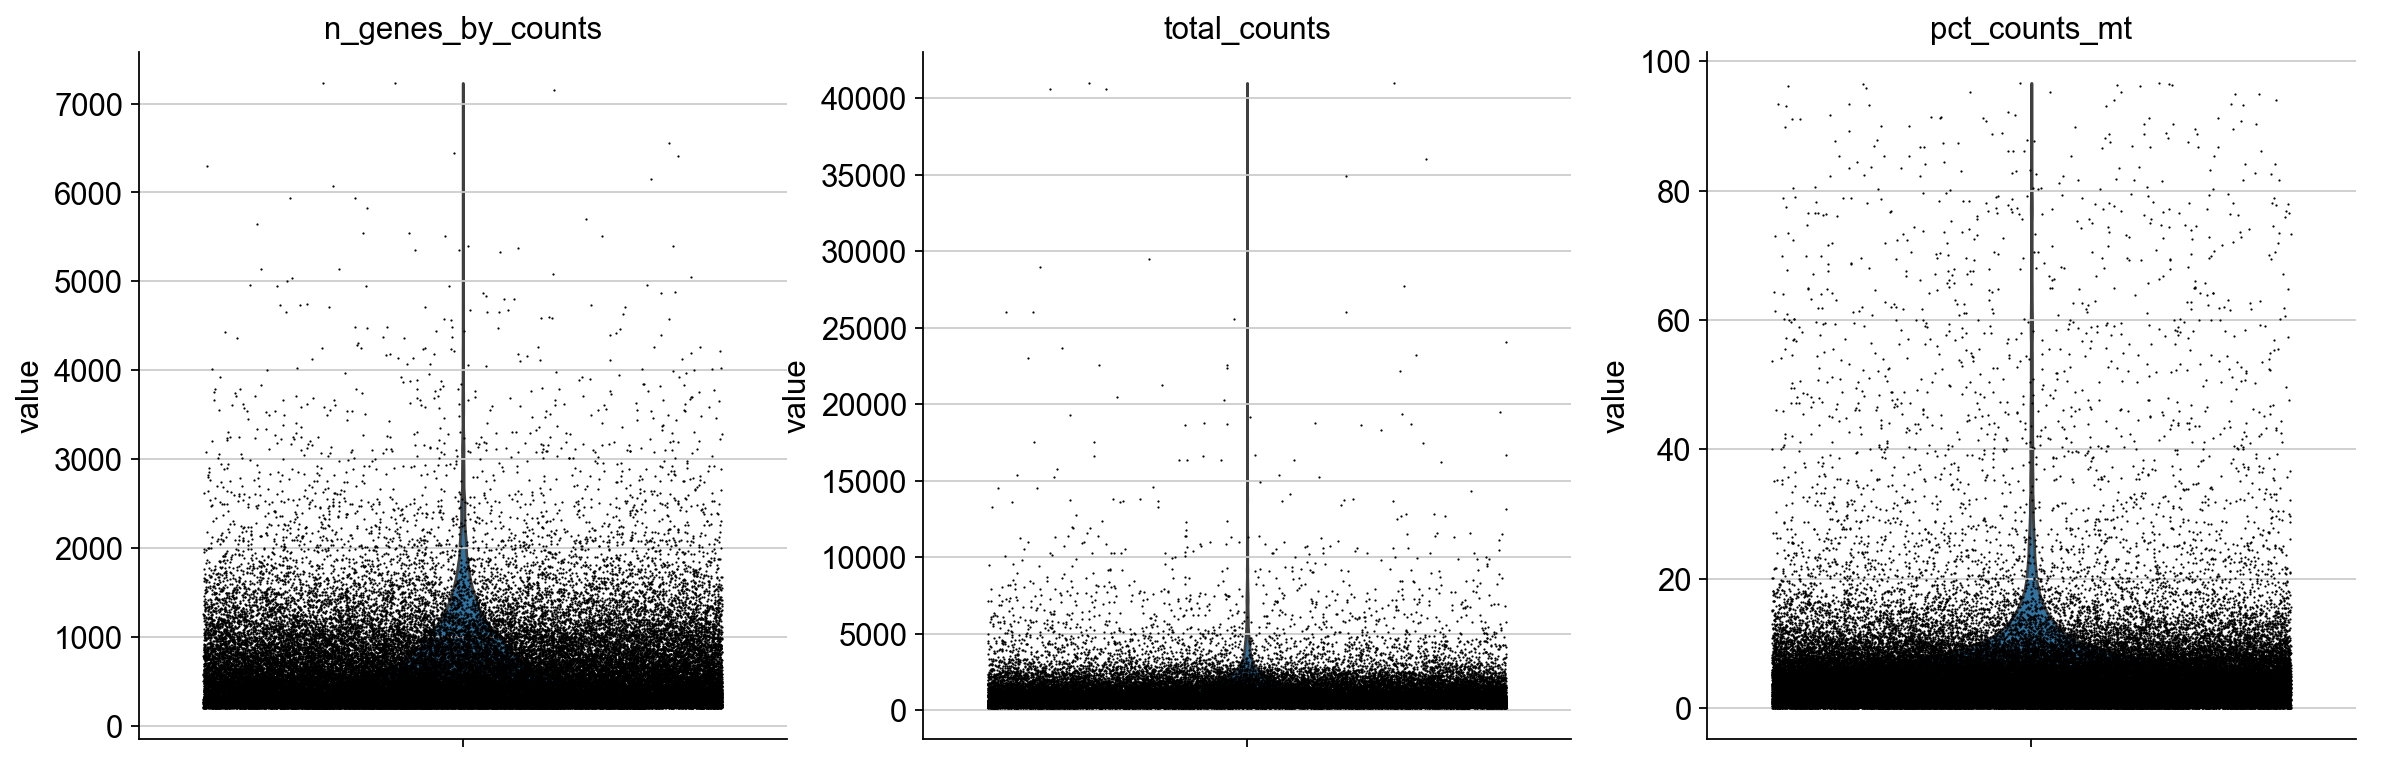

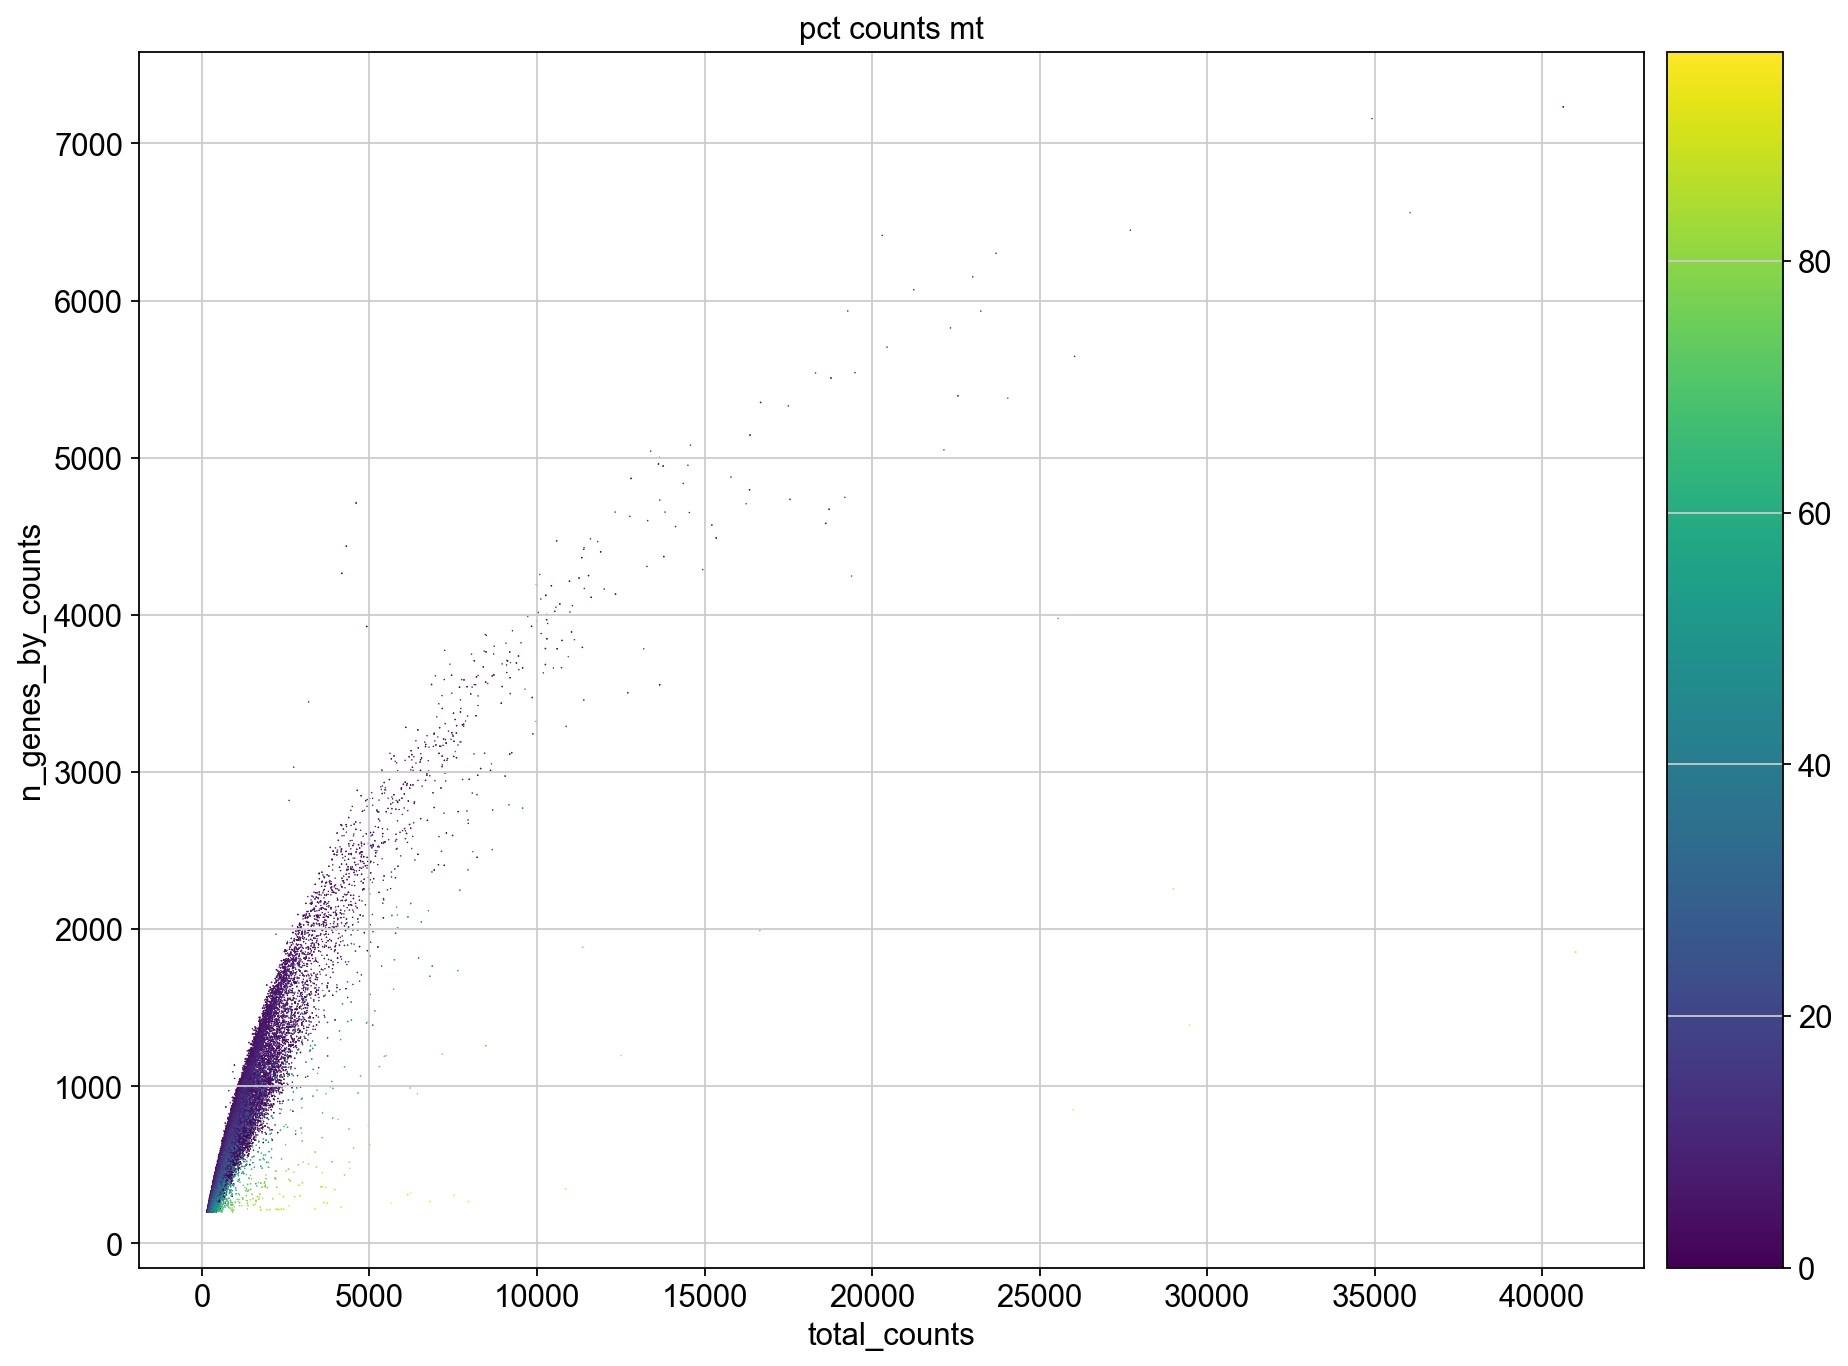

cell_id
853ab5348f619043ab2f997ac8ae14f0-AAAGGTACATGGCACC    0.854637
853ab5348f619043ab2f997ac8ae14f0-AAAGGTATCCAAGCTA    1.489082
853ab5348f619043ab2f997ac8ae14f0-AAAGTCCGTGCCGAAA    0.527533
853ab5348f619043ab2f997ac8ae14f0-AAAGTCCTCCGTATGA    0.000000
853ab5348f619043ab2f997ac8ae14f0-AAAGTGACAGTTGAAA    3.661873
Name: pct_counts_mt, dtype: float32
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 7.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.3%
Elapsed time: 88.1 seconds


C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\1015009835.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = doublet_scores


normalizing counts per cell
    finished (0:00:00)


C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\3917399443.py:32: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


c:\Program Files\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:27)


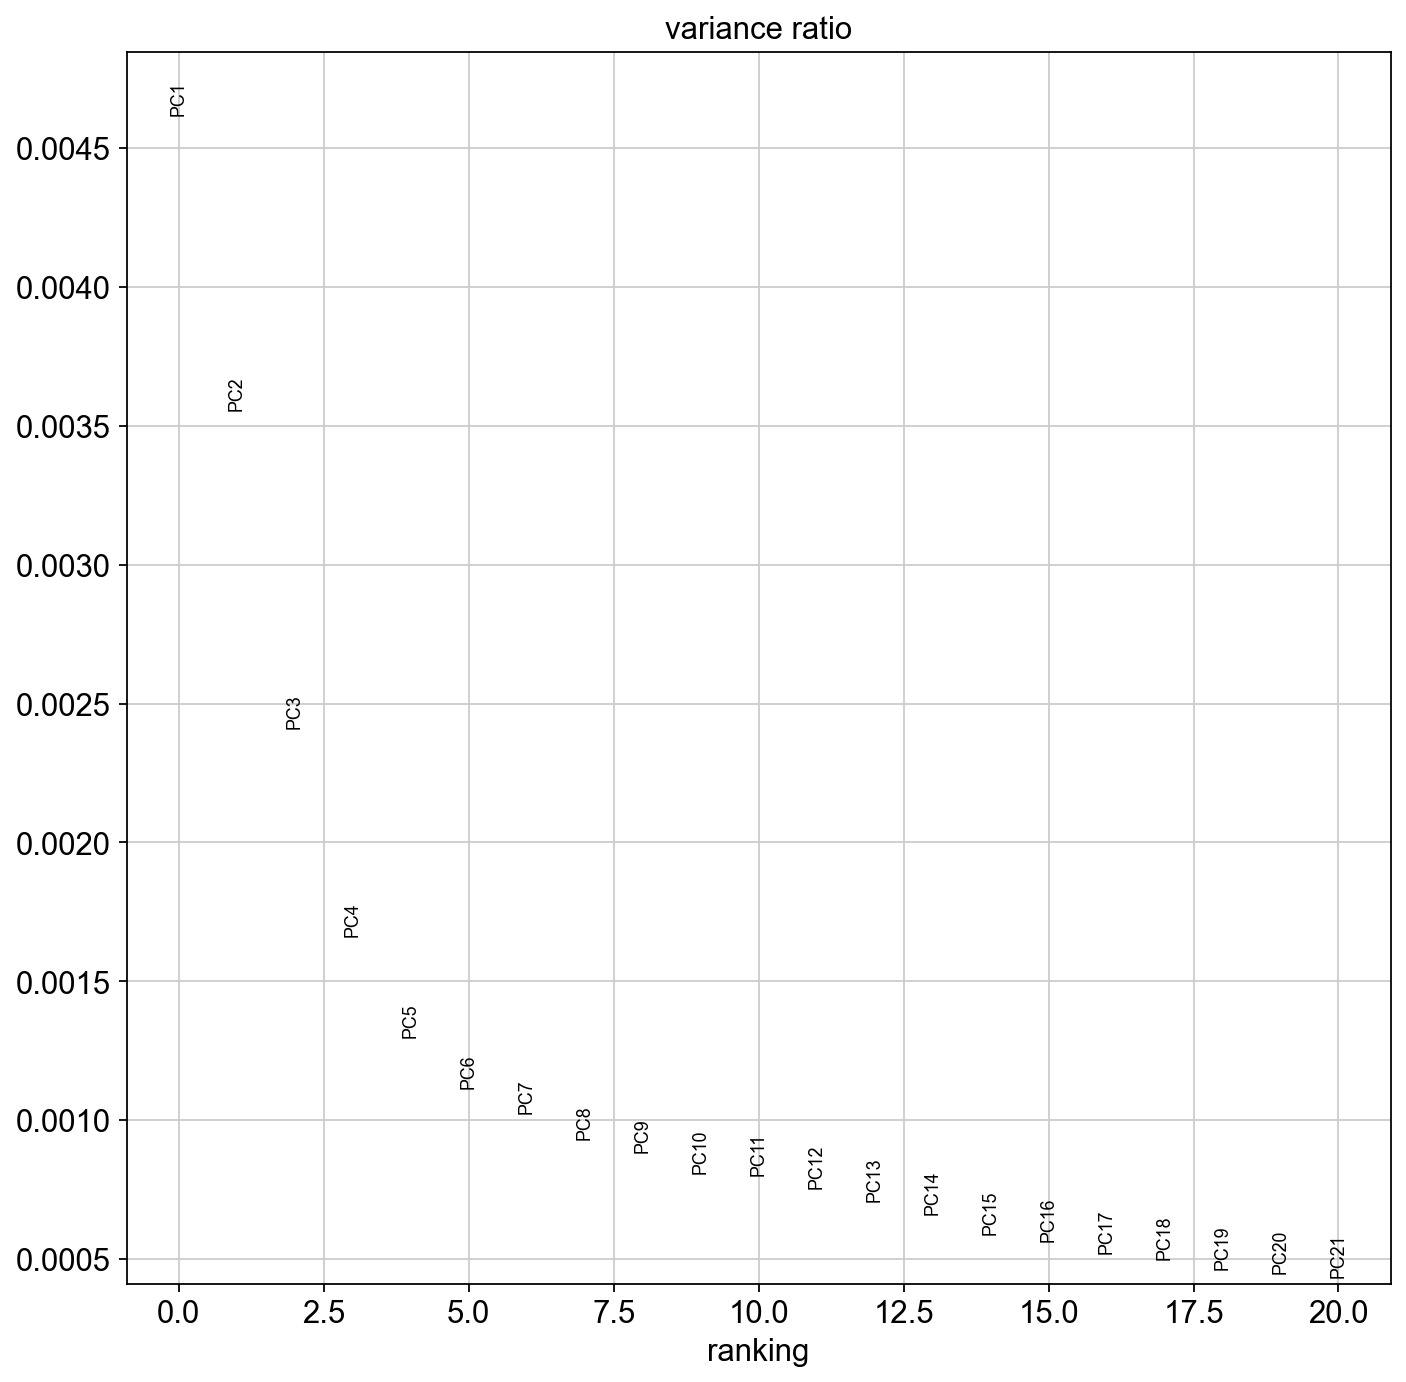

filtered out 538161 cells that have less than 200 genes expressed
filtered out 3901 genes that are detected in less than 3 cells


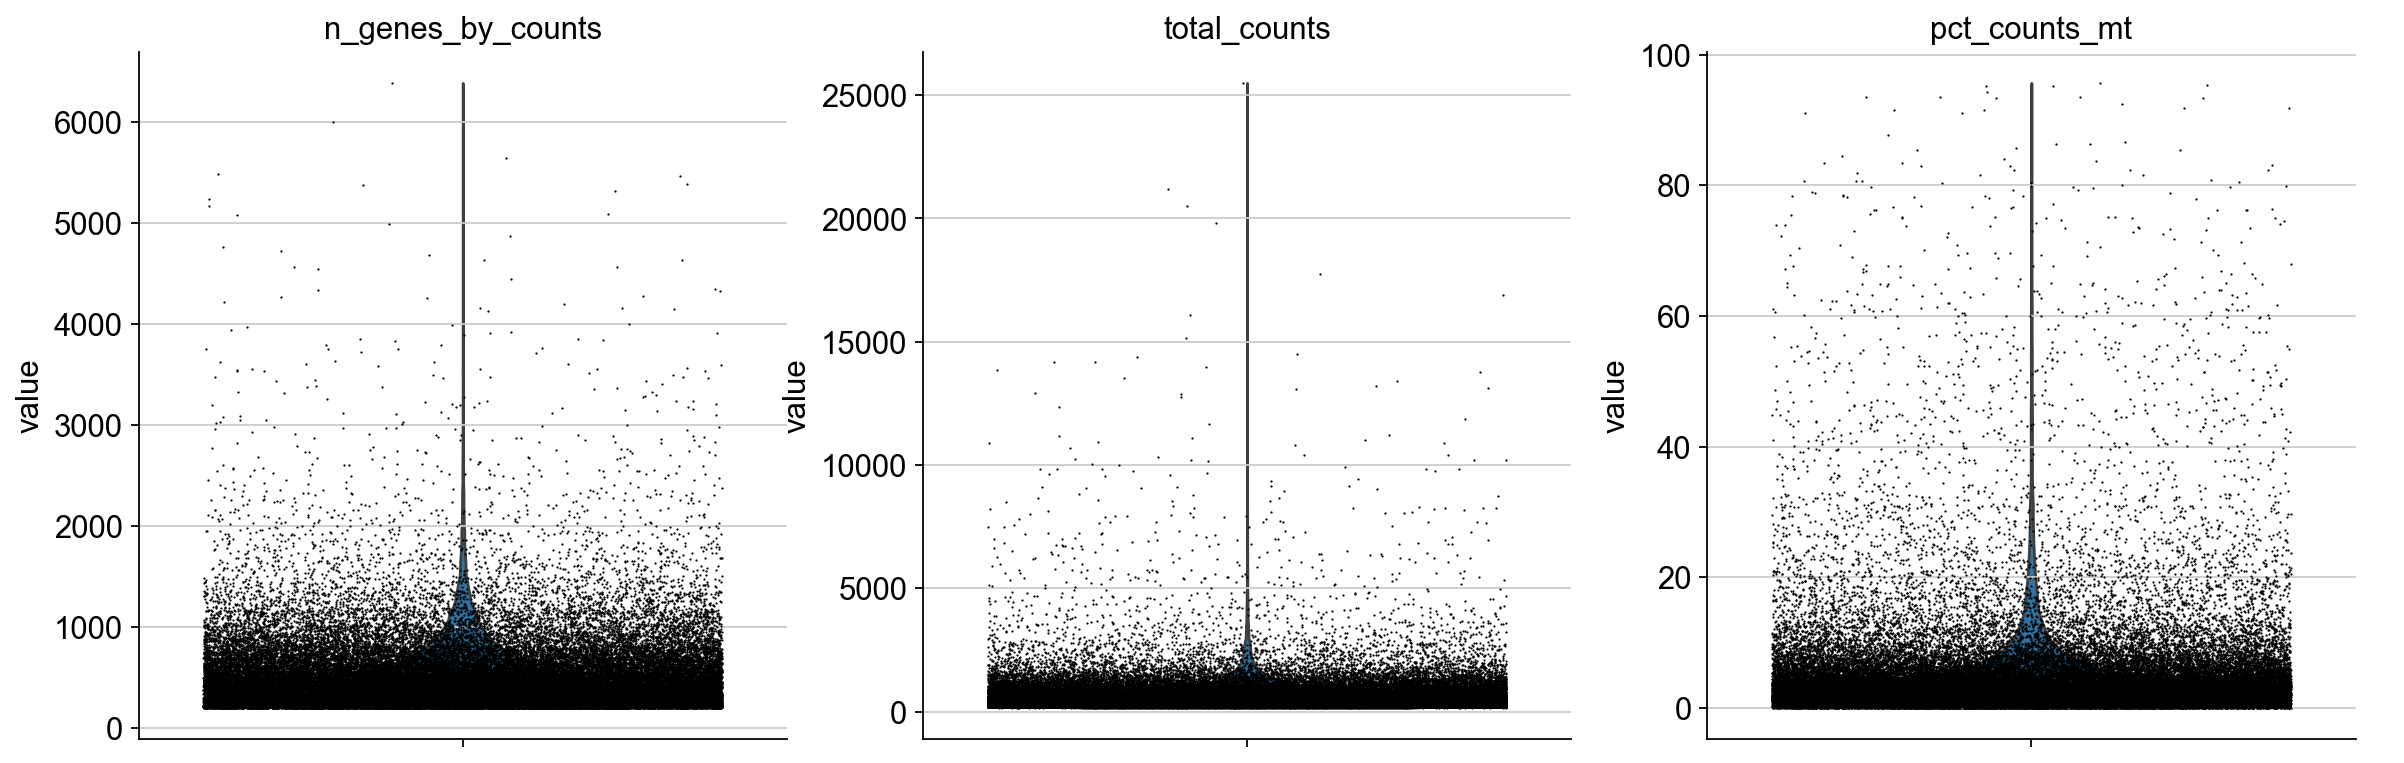

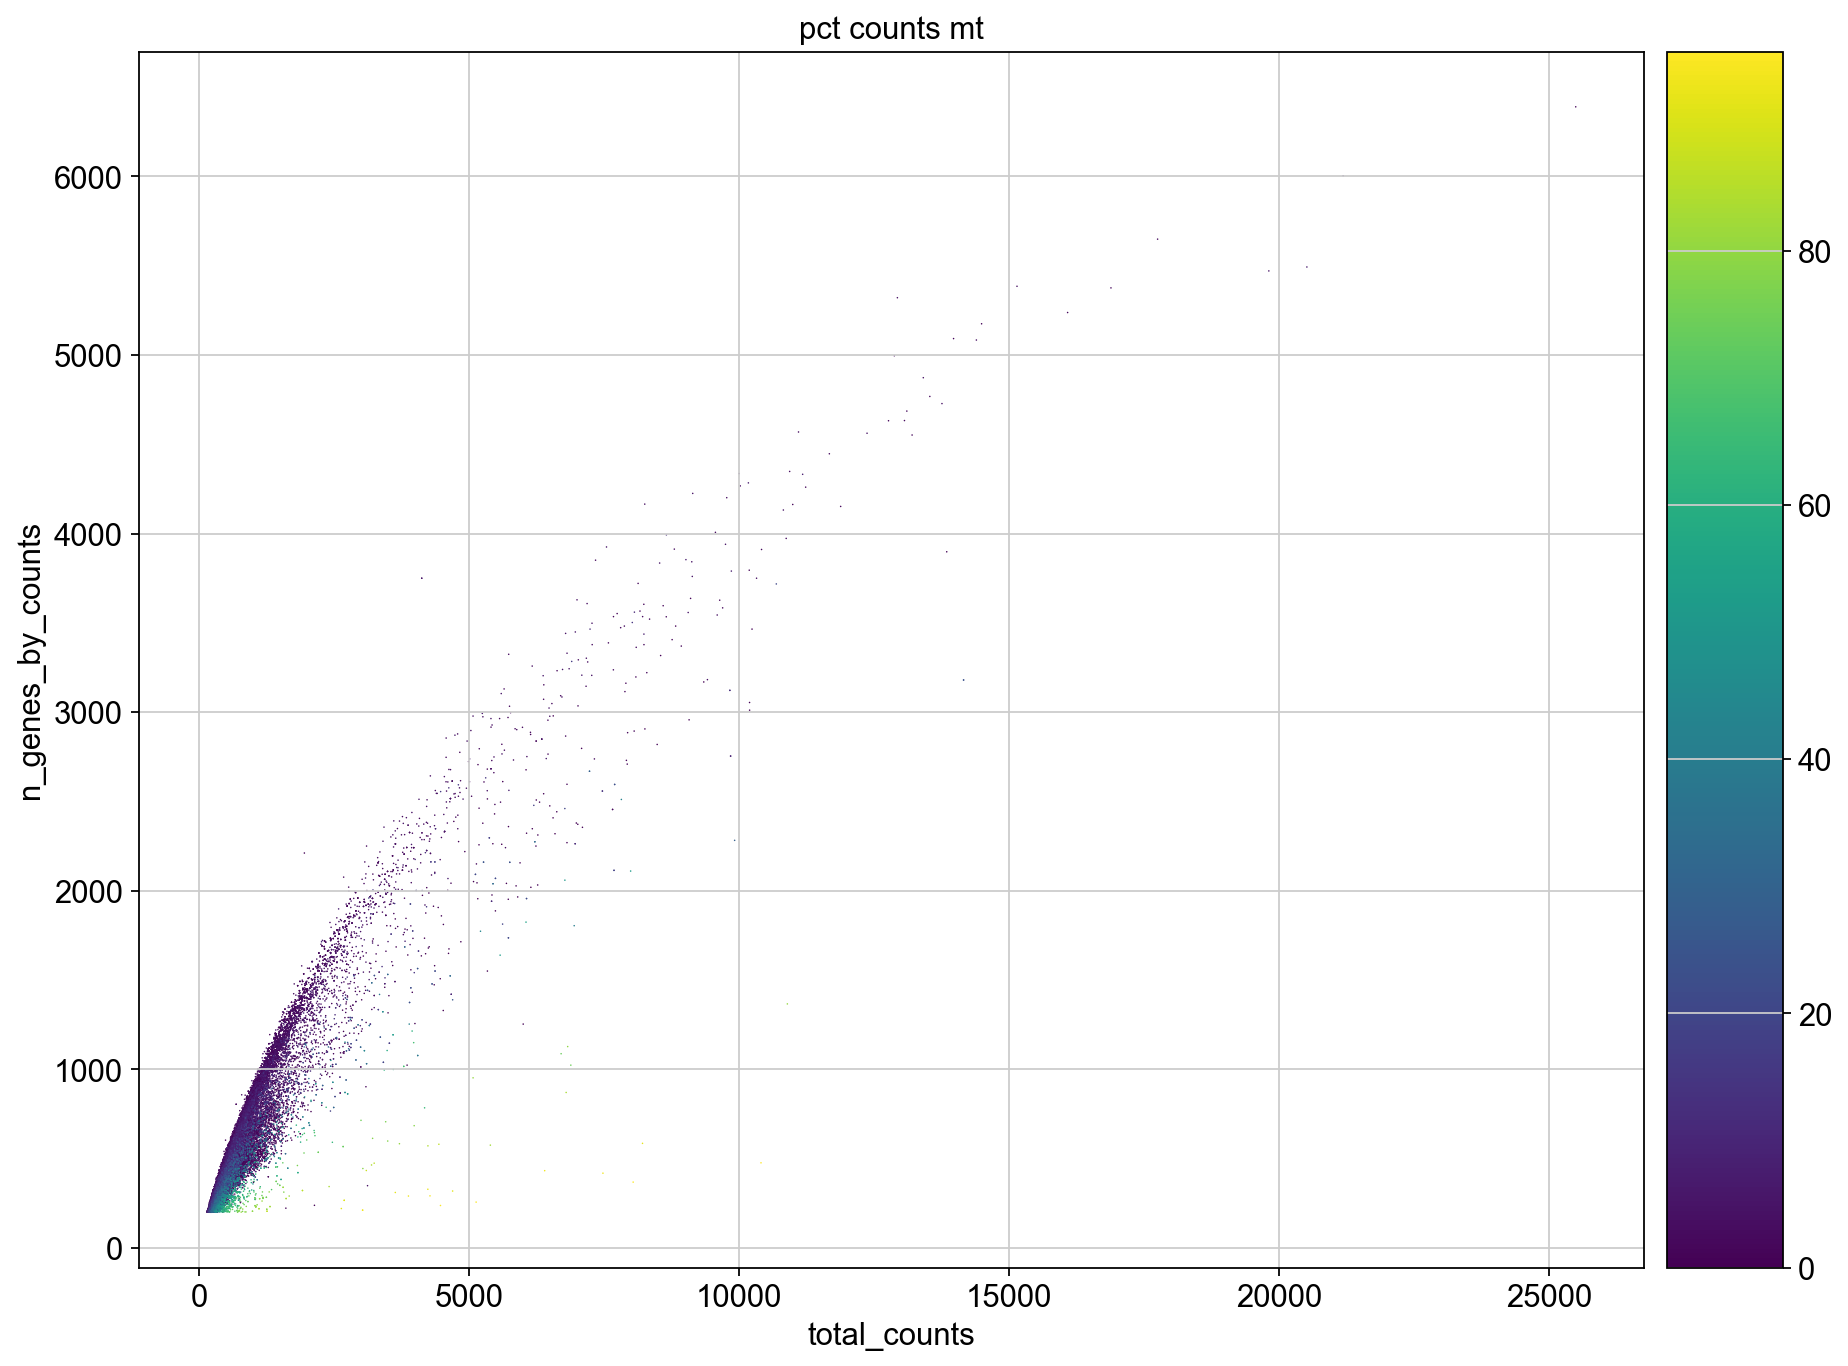

cell_id
0804a7a9e430e6adfbc56f339d787211-AAACATCGAAACATCGAAGGTACA     6.435124
0804a7a9e430e6adfbc56f339d787211-AAACATCGAACCGAGACTGTAGCC    18.955750
0804a7a9e430e6adfbc56f339d787211-AAACATCGAAGGACACAAGGTACA     7.648725
0804a7a9e430e6adfbc56f339d787211-AAACATCGAGTACAAGACAAGCTA     9.157342
0804a7a9e430e6adfbc56f339d787211-AAACATCGATAGCGACTATCAGCA     9.258018
Name: pct_counts_mt, dtype: float32
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 7.9%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.3%
Elapsed time: 67.8 seconds


C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\1015009835.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = doublet_scores
C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\3917399443.py:32: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


c:\Program Files\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:01)
computing PCA
    with n_comps=50
    finished (0:00:30)


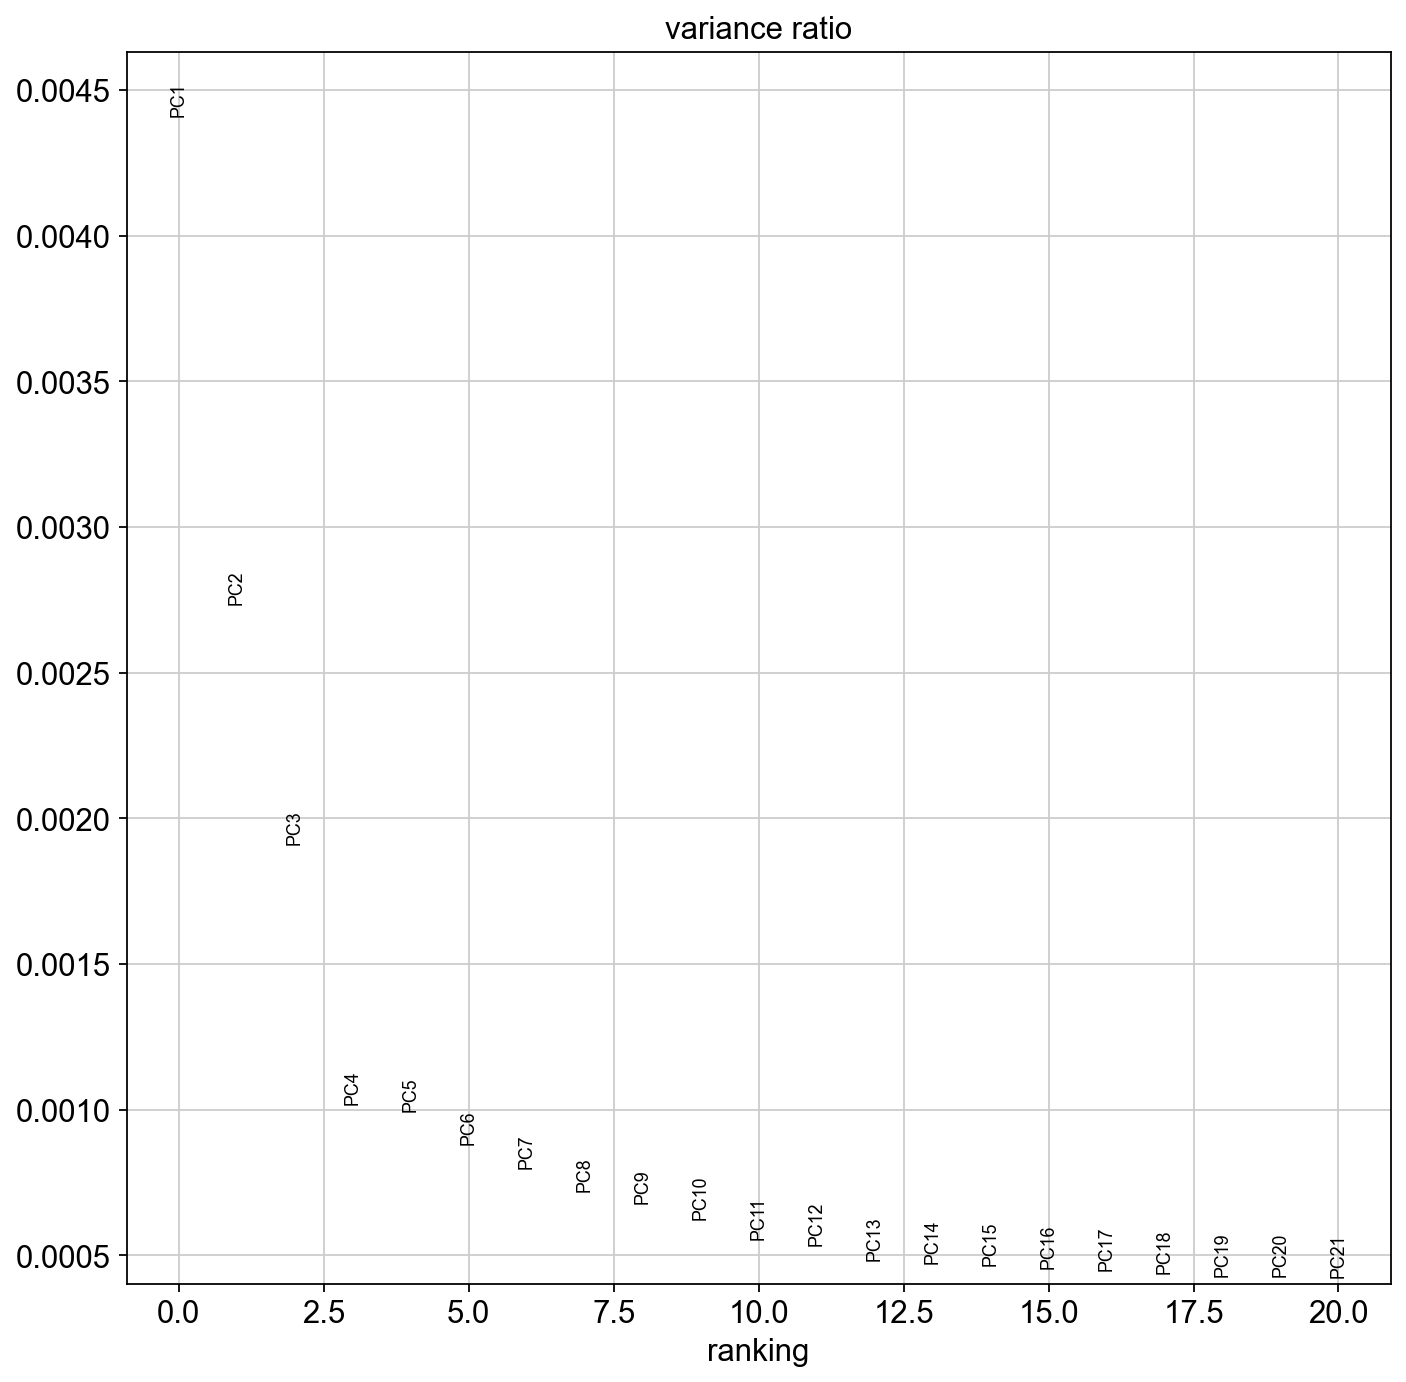

filtered out 4762 genes that are detected in less than 3 cells


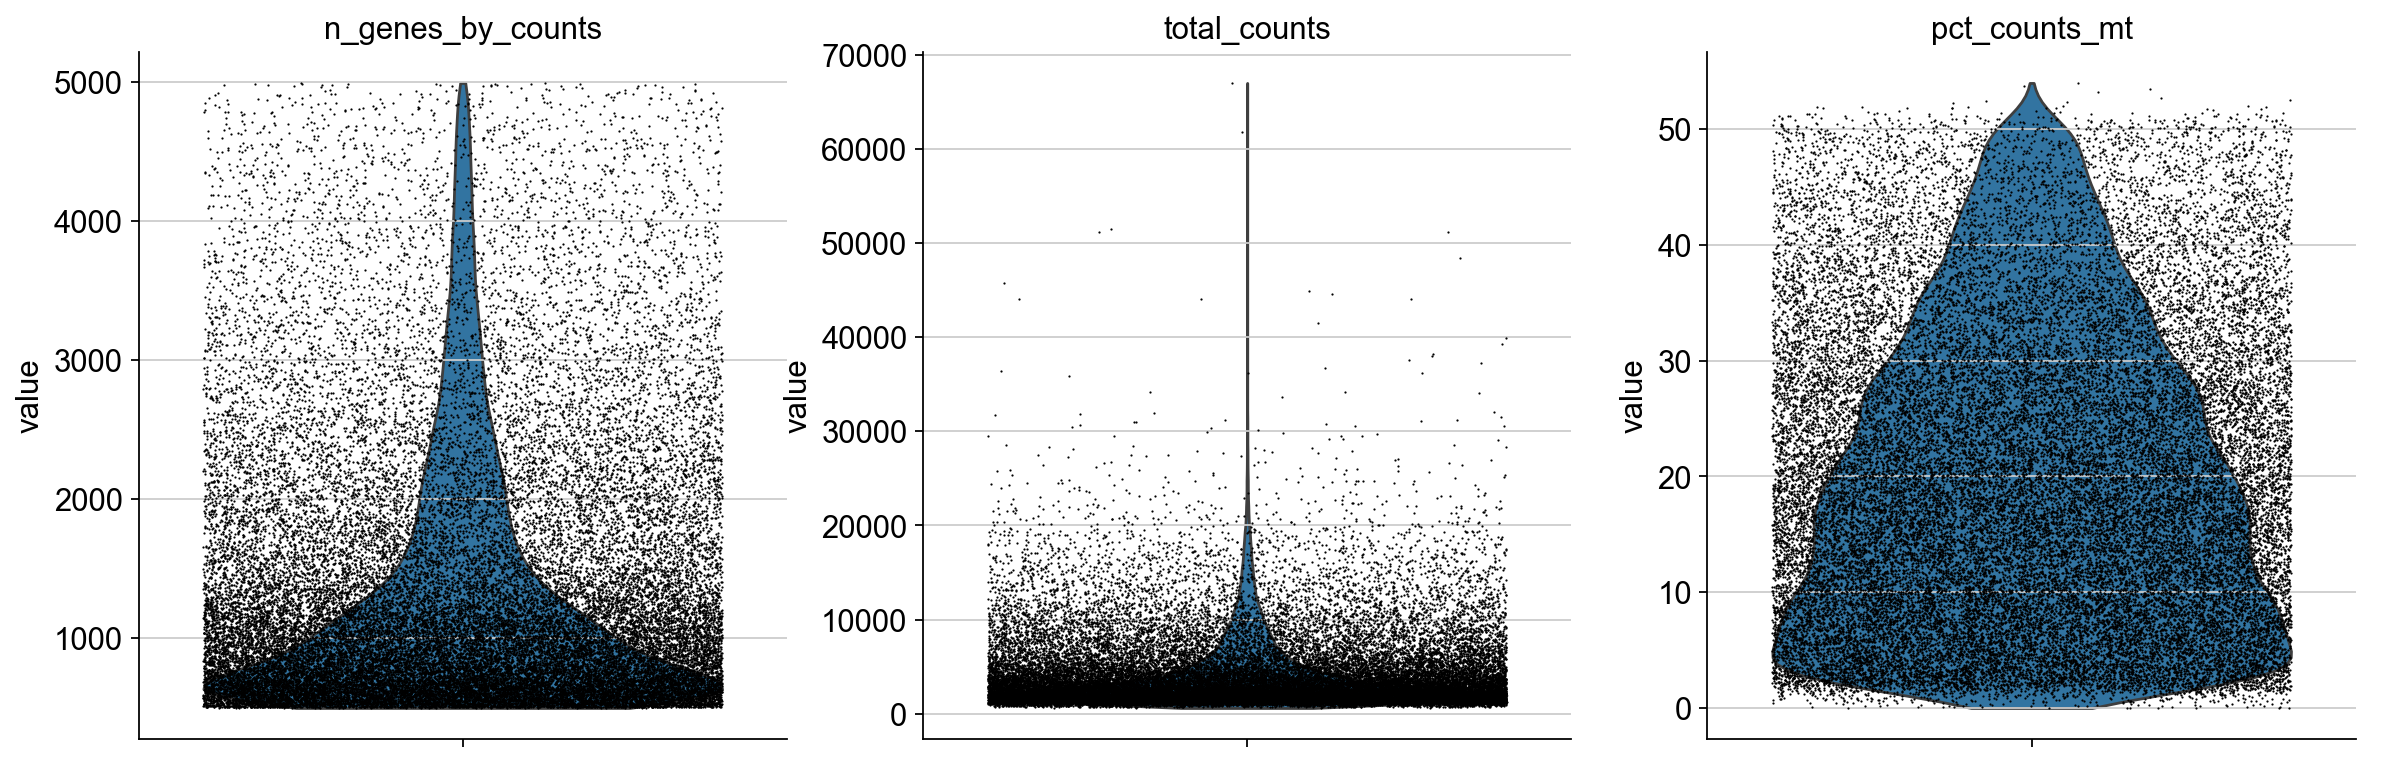

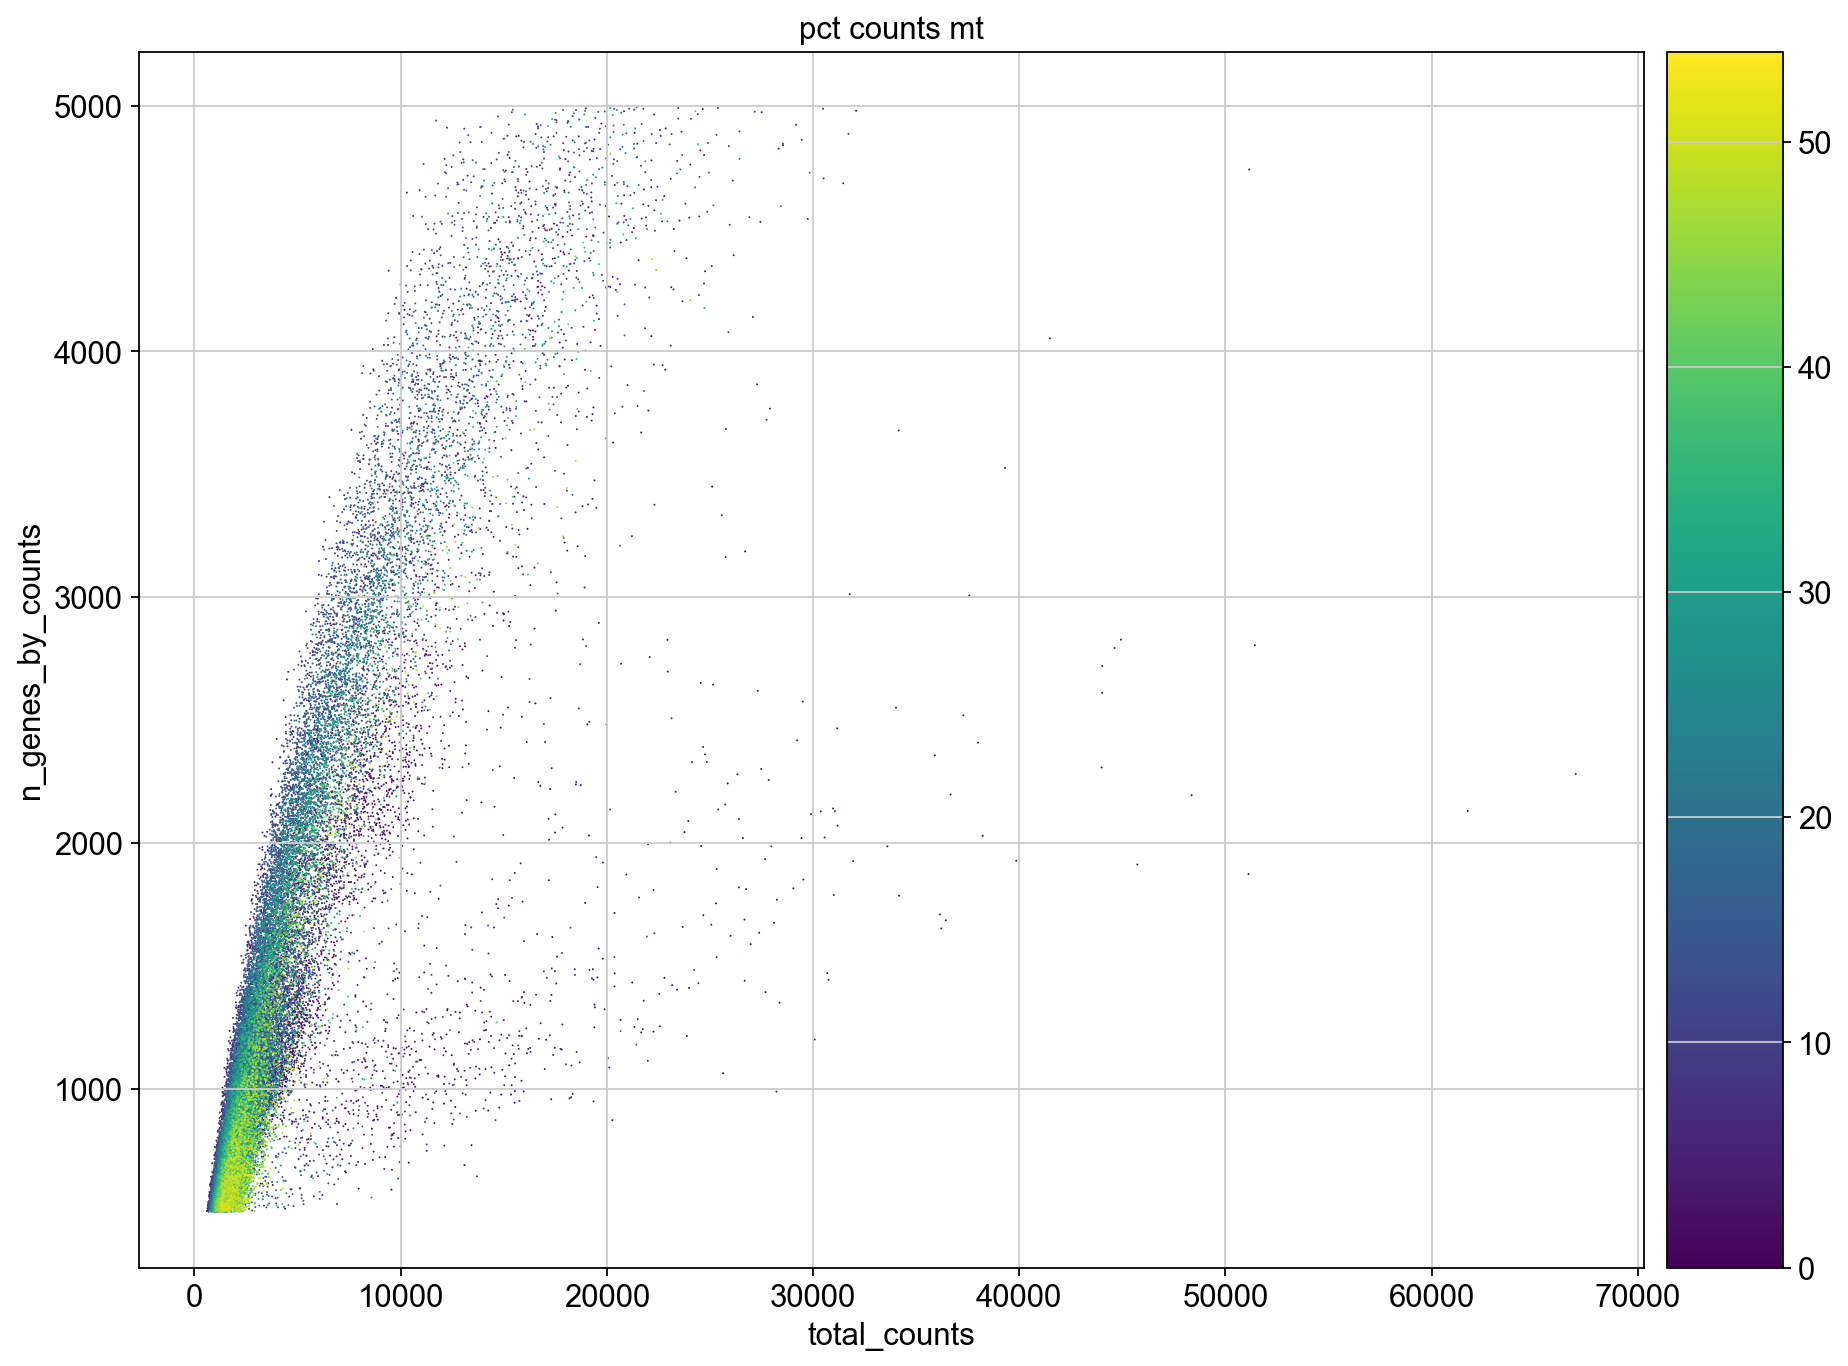

S2008000605HRT_AAGTGAACACTGCTTC-1     4.765665
S2008000605HRT_AATGGCTAGCCTCGTG-1    18.733746
S2008000605HRT_ACACAGTAGGAGGCAG-1     2.894705
S2008000605HRT_ACACGCGTCAAAGGTA-1    18.426167
S2008000605HRT_ACATTTCCAGCGGTTC-1    49.719673
Name: pct_counts_mt, dtype: float32
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Could not find library "annoy" for approx. nearest neighbor search
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 12.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.4%
Elapsed time: 57.3 seconds


C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\1015009835.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = doublet_scores
C:\Users\ruokun\AppData\Local\Temp\22\ipykernel_27436\3917399443.py:32: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


c:\Program Files\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:710: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:03)


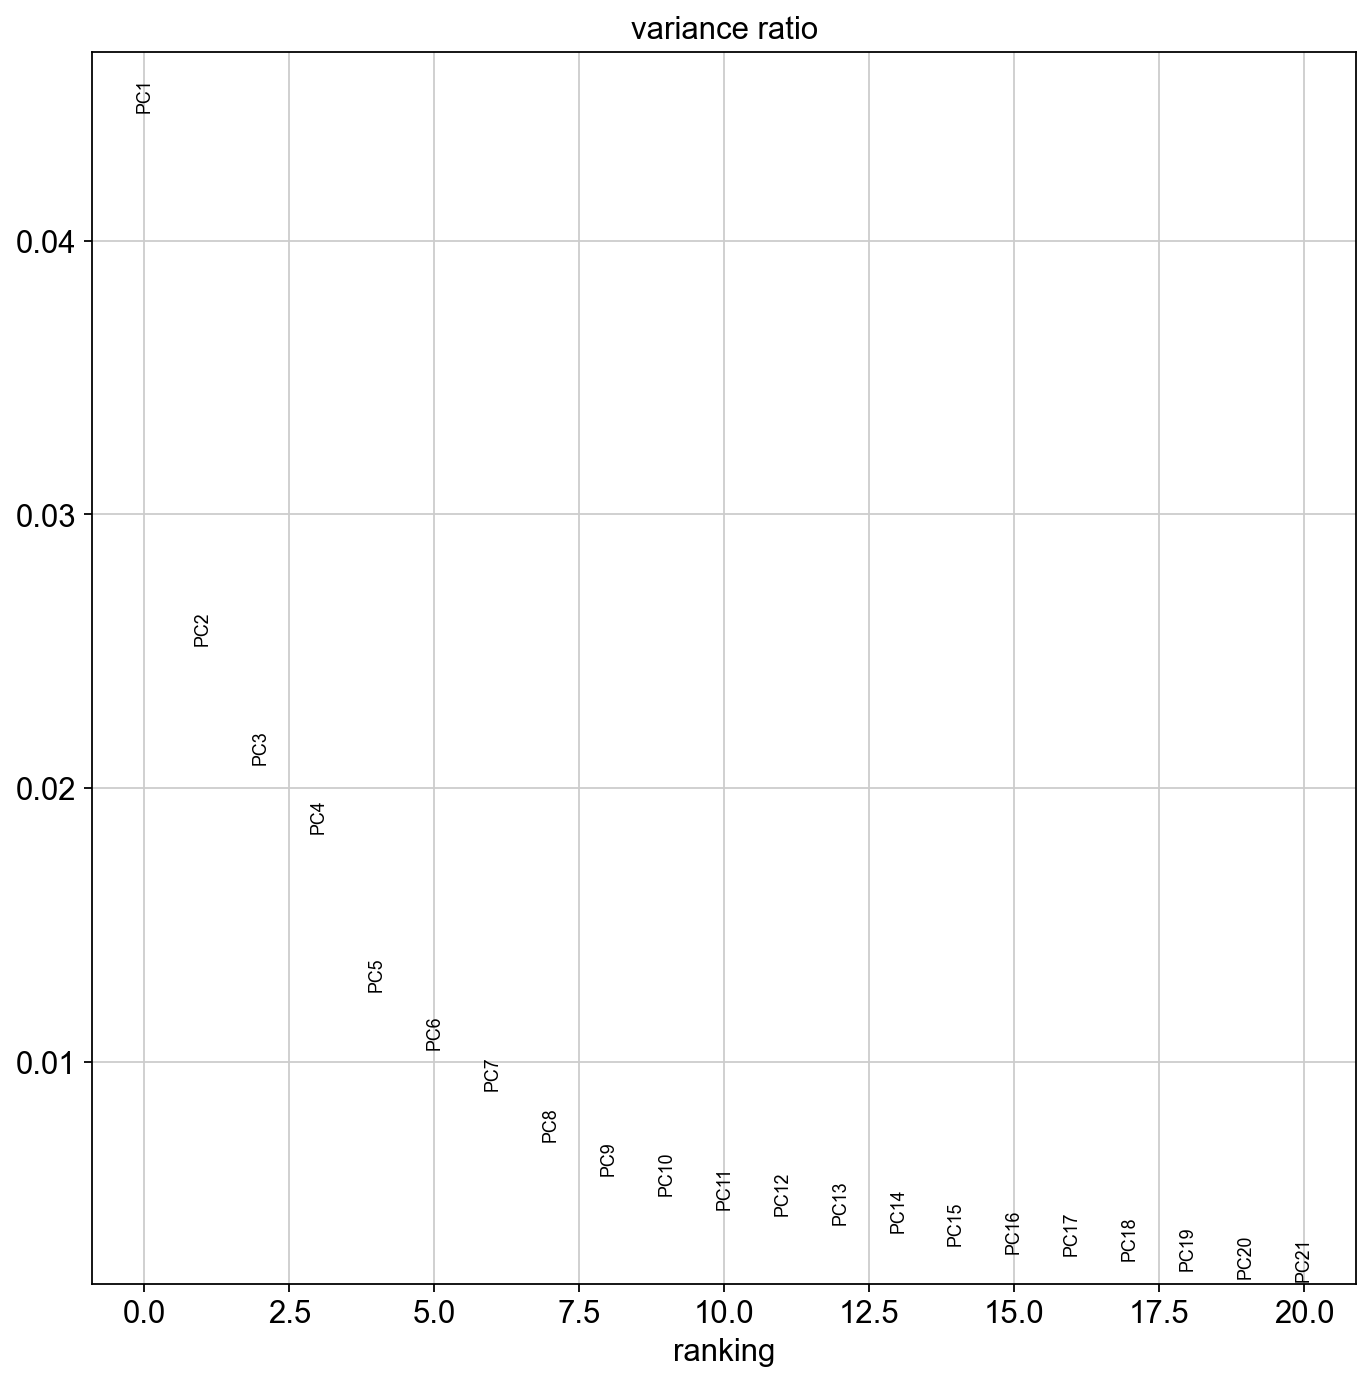

In [29]:
M='Harmony'
HuBMAP_LK_raw=QC_proccess(HuBMAP_LK_raw,'HuBMAP_LK',{
    'n_genes_by_counts':6000,
    'total_counts':90000,
    'pct_counts_mt':10
},scVI=False,method=M)
HuBMAP_RK_raw=QC_proccess(HuBMAP_RK_raw,'HuBMAP_RK',{
    'n_genes_by_counts':6000,
    'total_counts':90000,
    'pct_counts_mt':10
},scVI=False,method=M)
KPMP_SC_raw=QC_proccess(KPMP_SC_raw,'KPMP_SC',{
    'n_genes_by_counts':5000,
    'total_counts':20000,
    'pct_counts_mt':100
},scVI=False,method=M)


In [6]:
def data_integration_harmony(adata_list, batch_keys):
    adata = anndata.concat(adata_list, label="batch", keys=batch_keys,axis=0, join="inner", merge="first")
    # sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch', basis='X_pca')
    sc.pp.neighbors(adata, use_rep='X_pca_harmony')
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.pl.umap(adata, color=['batch','cl_label','disease'],save='harmony_umap.png')
    return adata


2025-04-01 15:10:27,891 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-01 15:10:36,600 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-01 15:10:37,128 - harmonypy - INFO - Iteration 1 of 10
2025-04-01 15:11:28,894 - harmonypy - INFO - Iteration 2 of 10
2025-04-01 15:12:12,938 - harmonypy - INFO - Iteration 3 of 10
2025-04-01 15:12:56,653 - harmonypy - INFO - Iteration 4 of 10
2025-04-01 15:13:40,091 - harmonypy - INFO - Iteration 5 of 10
2025-04-01 15:14:22,726 - harmonypy - INFO - Iteration 6 of 10
2025-04-01 15:15:02,259 - harmonypy - INFO - Iteration 7 of 10
2025-04-01 15:15:46,266 - harmonypy - INFO - Iteration 8 of 10
2025-04-01 15:16:23,593 - harmonypy - INFO - Converged after 8 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:16)
running Leiden clustering
    finished: found 38 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)


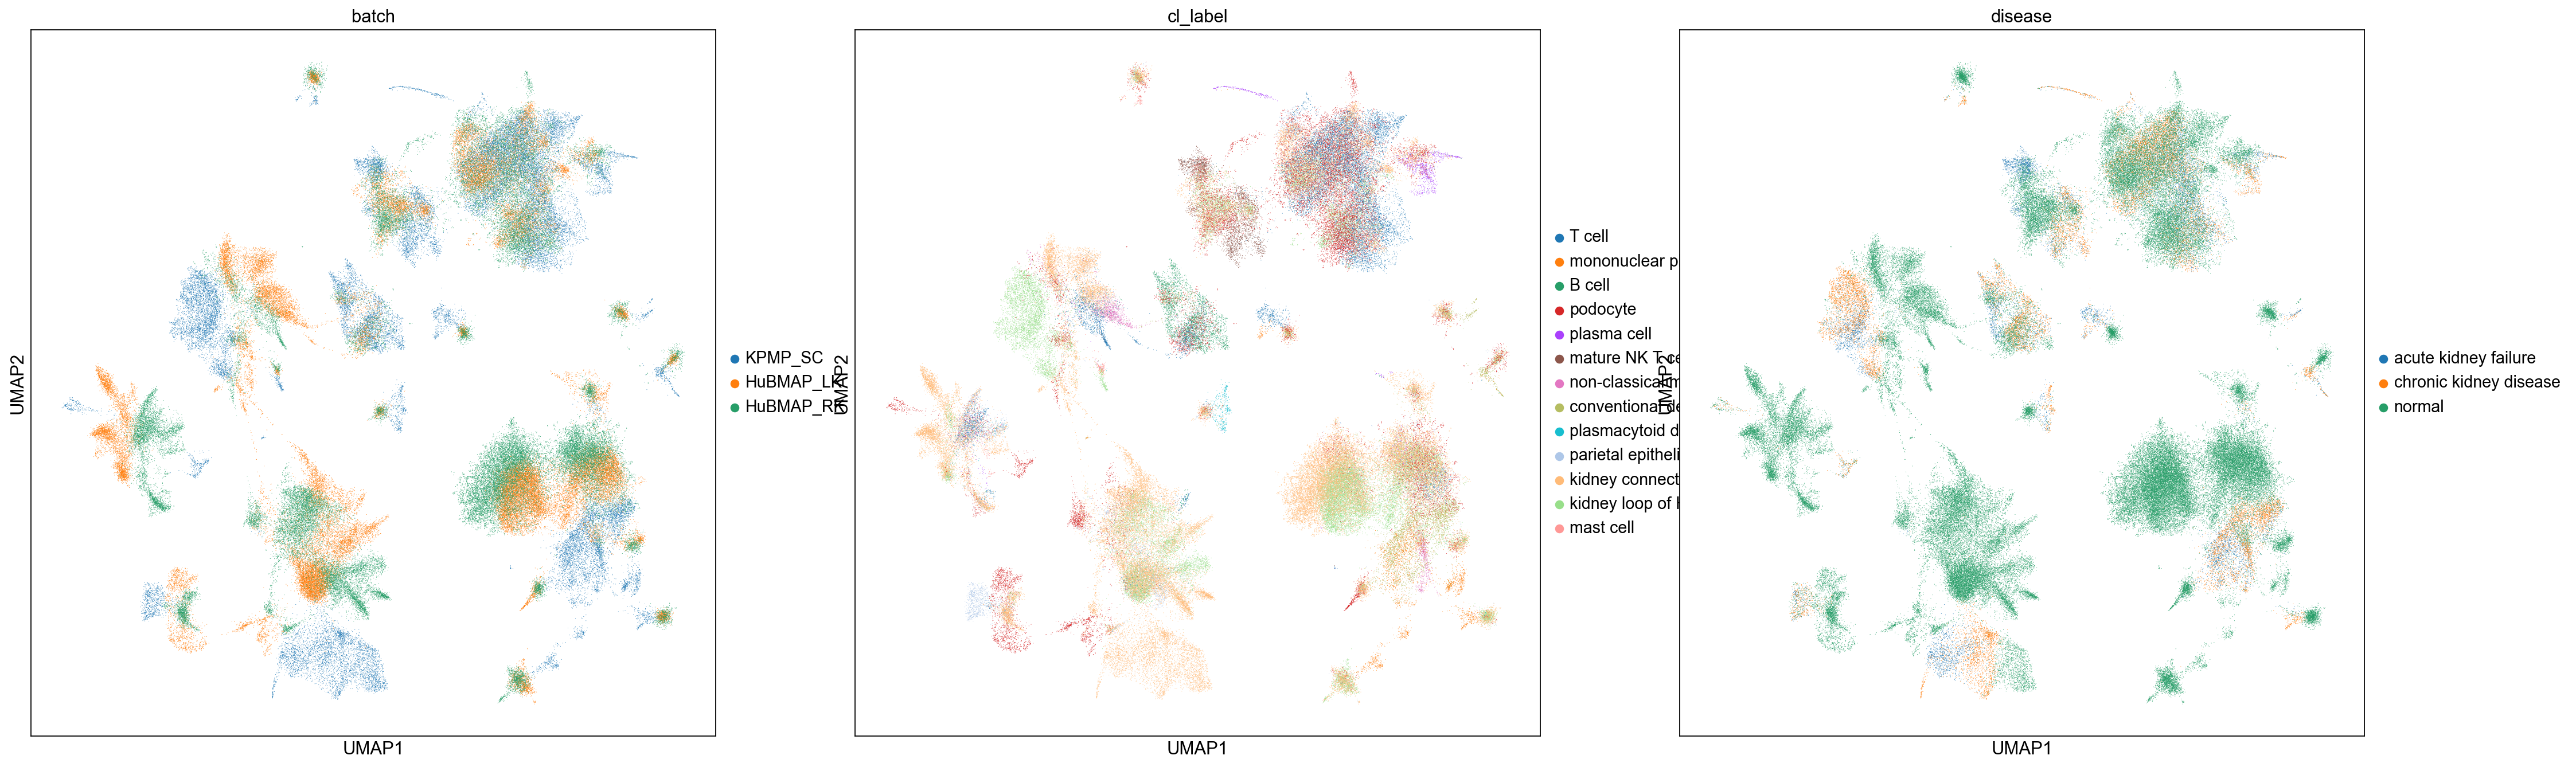

In [10]:
concat_data=data_integration_harmony([KPMP_SC_raw, HuBMAP_LK_raw,HuBMAP_RK_raw],
                           ["KPMP_SC", "HuBMAP_LK","HuBMAP_RK"])

In [23]:
concat_data.obs['age'] = concat_data.obs['age'].astype(str)
concat_data.write_h5ad('data_saving/harmony_proccessed_data_LK_RK_KPMP.h5ad')

In [18]:
def data_integration_BBNK(adata_list, batch_keys):
    # 3. Concatenate all datasets (note: ingest step removed)
    adata_concat = anndata.concat(adata_list, label="batch", keys=batch_keys,
    axis=0, join="inner", merge="first")
    sc.external.pp.bbknn(adata_concat, batch_key="batch")
    sc.tl.leiden(adata_concat,resolution='0.6')
    sc.tl.umap(adata_concat)
    sc.pl.umap(adata_concat, color=['batch','cl_label','disease'],save='bbnkk_LK_KPMP_umap.png')
    
    return adata_concat

In [30]:
LK_KPMP_C=sc.read('data_saving\harmony_proccessed_data_LK_KPMP.h5ad')


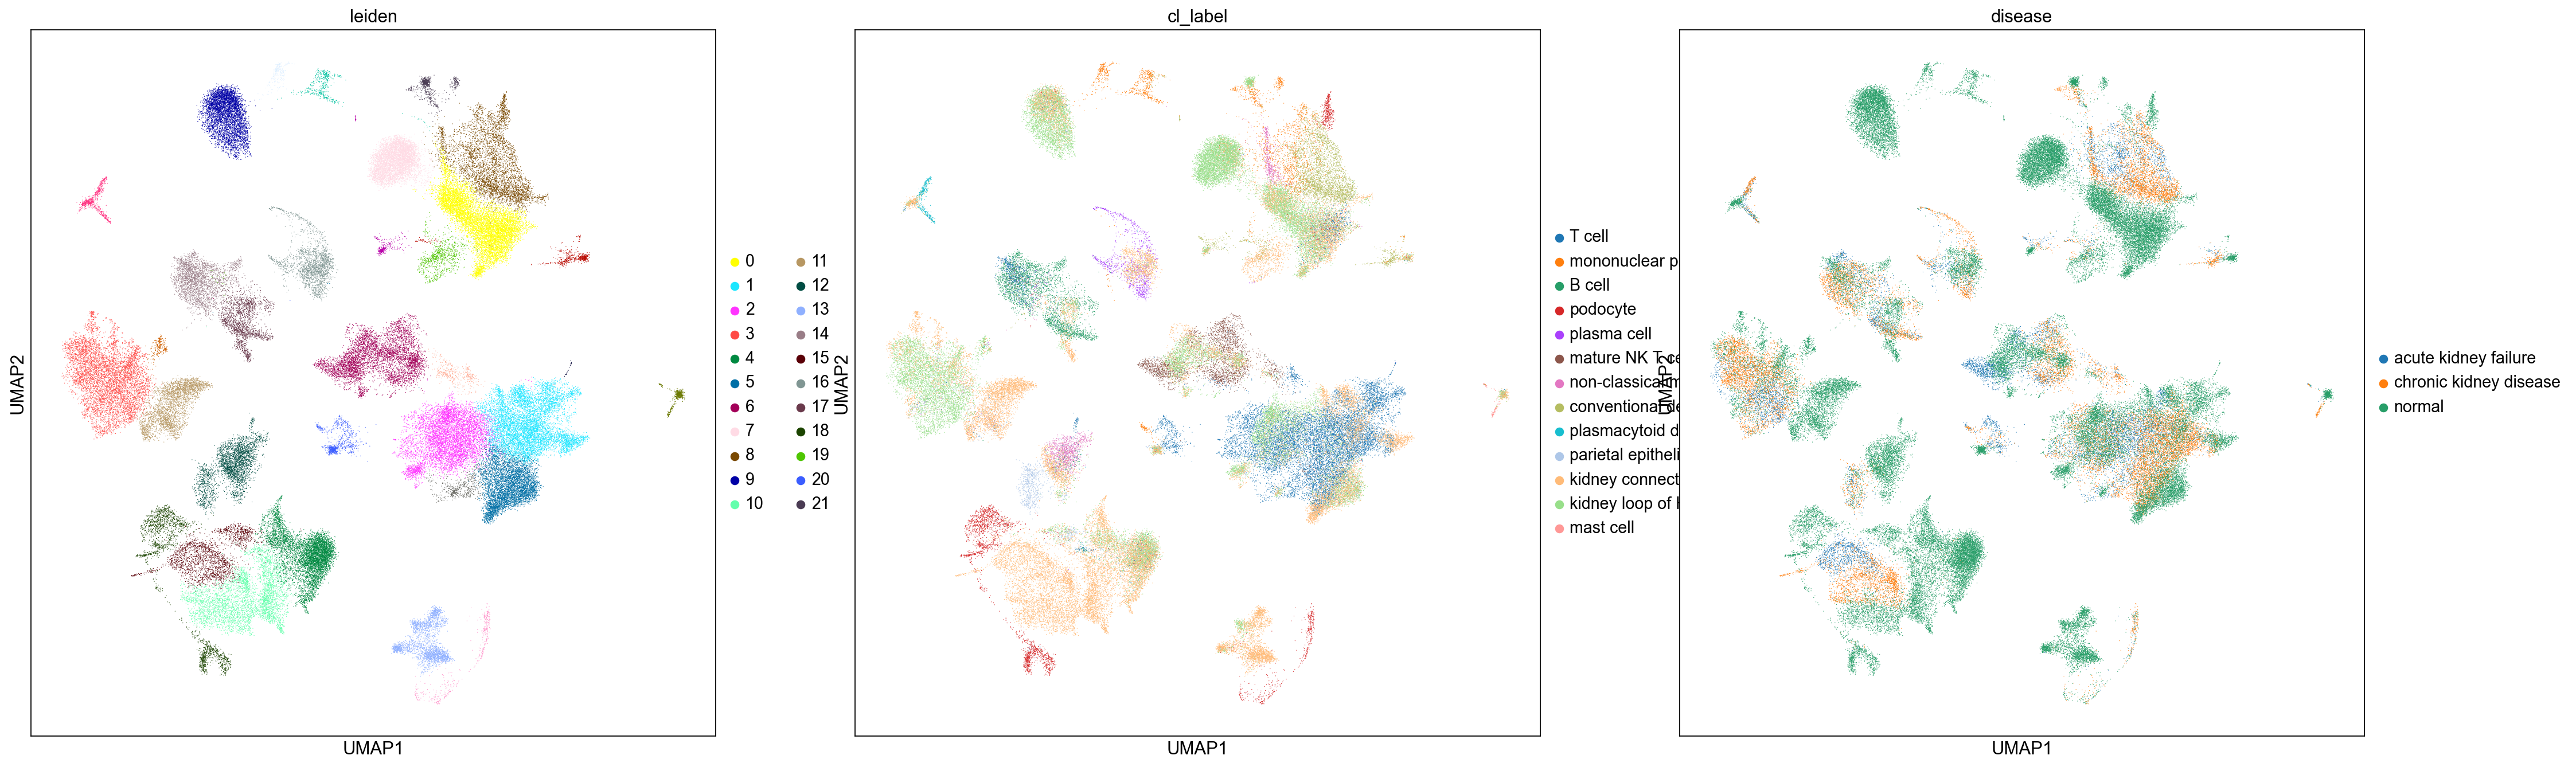

In [31]:
sc.pl.umap(LK_KPMP_C, color=['leiden','cl_label','disease'],save='LK_KPMP.png')

In [22]:
import importlib.metadata
print(importlib.metadata.version("scrublet"))


0.2.3
